# ⚡ EnerVision — Energy Consumption & Demand Forecasting

**Project:** EnerVision — Smart-meter aggregated energy consumption analysis and demand forecasting.

**Dataset:** `energy_consumption_2000_rows.csv` (2000 hourly rows, aggregated region-level consumption)

This Colab notebook shows EDA, seasonality/trend decomposition, and ARIMA forecasting.

## 1) Install & Imports

In [21]:
# Optional: install prophet in Colab
# !pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

sns.set(style='whitegrid')

# Load dataset (ensure it's uploaded in /content if using Colab)
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('/content/energy_consumption_2000_rows.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df.head()


Saving energy_consumption_2000_rows.csv to energy_consumption_2000_rows (2).csv


,timestamp,consumption_kwh,temperature_C,hour,day_of_week,day_name,rolling_mean_24h,rolling_std_24h,lag_24h,is_holiday,is_weekend,is_peak_hour,is_offpeak
0,2025-08-19 08:45:39.584798,3145.67,20.19,8,1,Tuesday,3145.67,0.00,3145.67,0,0,0,0
1,2025-08-19 09:45:39.584798,3139.96,19.68,9,1,Tuesday,3142.82,4.04,3145.67,0,0,0,0
2,2025-08-19 10:45:39.584798,2961.95,20.97,10,1,Tuesday,3082.53,104.46,3145.67,0,0,0,0
3,2025-08-19 11:45:39.584798,2806.00,22.05,11,1,Tuesday,3013.40,162.45,3145.67,0,0,0,0
4,2025-08-19 12:45:39.584798,2424.50,18.86,12,1,Tuesday,2895.62,298.59,3145.67,0,0,0,0


## 2) Quick EDA

Rows: 2000
                   count                           mean  \
timestamp           2000  2025-09-30 00:15:39.584798208   
consumption_kwh   2000.0                     1929.74301   
temperature_C     2000.0                      15.082605   
hour              2000.0                           11.5   
day_of_week       2000.0                           3.02   
rolling_mean_24h  2000.0                     1930.95379   
rolling_std_24h   2000.0                      826.75528   
lag_24h           2000.0                    1944.093195   
is_holiday        2000.0                          0.116   
is_weekend        2000.0                          0.288   
is_peak_hour      2000.0                          0.166   
is_offpeak        2000.0                          0.249   

                                         min                            25%  \
timestamp         2025-08-19 08:45:39.584798  2025-09-09 04:30:39.584797952   
consumption_kwh                       482.95                   

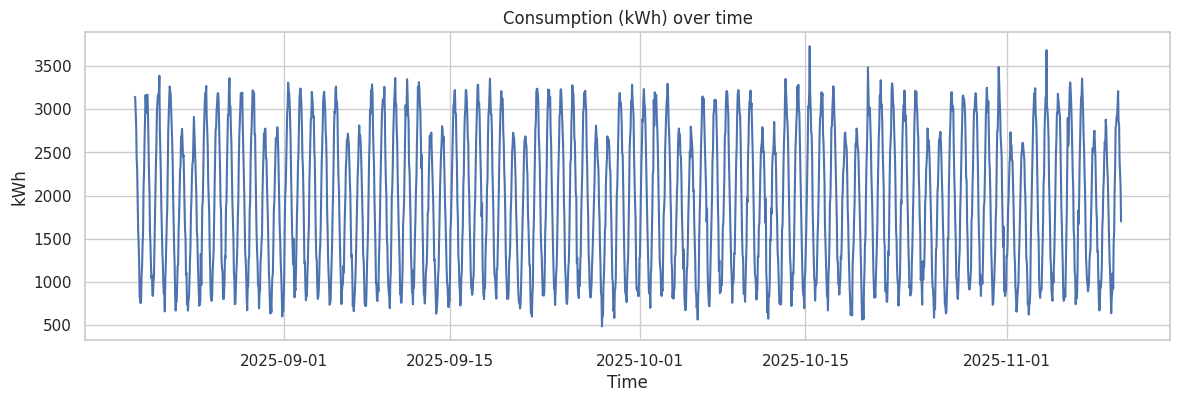

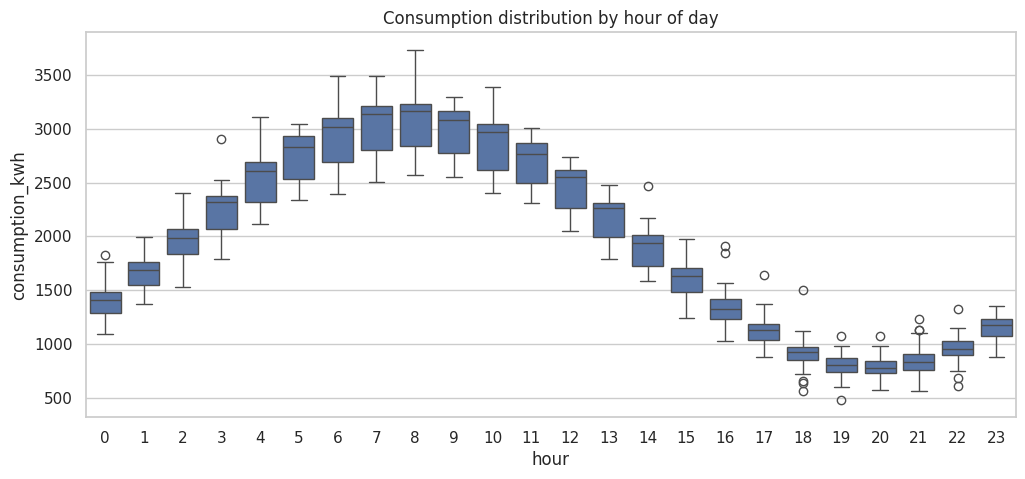

In [22]:
print("Rows:", len(df))
print(df.describe().T)

plt.figure(figsize=(14,4))
plt.plot(df['timestamp'], df['consumption_kwh'])
plt.title('Consumption (kWh) over time')
plt.xlabel('Time'); plt.ylabel('kWh')
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='hour', y='consumption_kwh', data=df)
plt.title('Consumption distribution by hour of day')
plt.show()

## 3) Decomposition (trend + seasonality)

/tmp/ipython-input-603688530.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df.set_index('timestamp')['consumption_kwh'].asfreq('H')


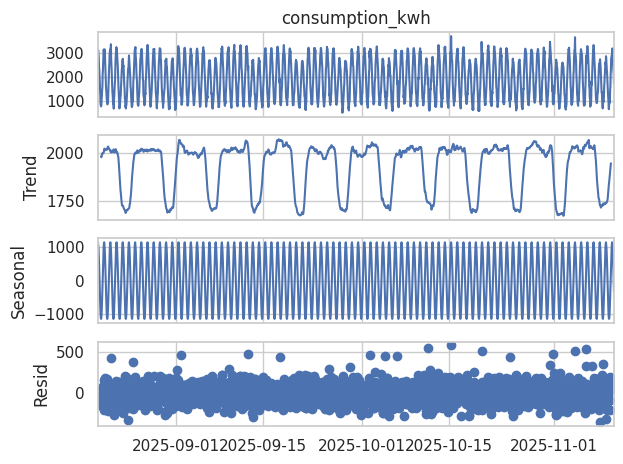

In [23]:
series = df.set_index('timestamp')['consumption_kwh'].asfreq('H')
res = seasonal_decompose(series, model='additive', period=24)
res.plot(); plt.show()

## 4) Train/Test Split

In [24]:
horizon = 168
train = df[:-horizon].set_index('timestamp')
test = df[-horizon:].set_index('timestamp')
print('Train rows:', len(train), 'Test rows:', len(test))

Train rows: 1832 Test rows: 168


## 5) Baseline Forecasts

In [25]:
naive_forecast = test['consumption_kwh'].shift(24).fillna(method='bfill')
print("Naive MAE:", mean_absolute_error(test['consumption_kwh'], naive_forecast))

rolling_forecast_value = train['consumption_kwh'].rolling(window=24).mean().iloc[-1]
rolling_pred = pd.Series(rolling_forecast_value, index=test.index)
print("24h rolling constant MAE:", mean_absolute_error(test['consumption_kwh'], rolling_pred))

Naive MAE: 272.40172619047615
24h rolling constant MAE: 733.9801835317461


/tmp/ipython-input-532527439.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  naive_forecast = test['consumption_kwh'].shift(24).fillna(method='bfill')


## 6) ARIMA Forecasting

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:        consumption_kwh   No. Observations:                 1832
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -11502.122
Date:                Tue, 11 Nov 2025   AIC                          23020.243
Time:                        15:06:41   BIC                          23064.344
Sample:                    08-19-2025   HQIC                         23036.509
                         - 11-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9690      0.038     25.208      0.000       0.894       1.044
ar.L2          0.1545      0.038      4.083      0.000       0.080       0.229
ar.L3          0.0375      0.035      1.085      0.2

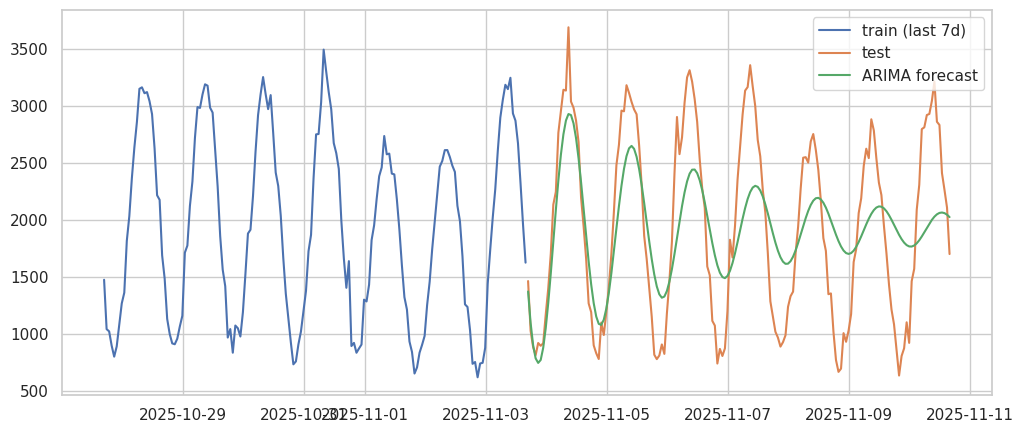

In [26]:
train_series = train['consumption_kwh']
model = ARIMA(train_series, order=(5,1,2))
model_fit = model.fit()
print(model_fit.summary())

arima_forecast = model_fit.forecast(steps=len(test))
print("ARIMA MAE:", mean_absolute_error(test['consumption_kwh'], arima_forecast))

plt.figure(figsize=(12,5))
plt.plot(train.index[-7*24:], train['consumption_kwh'][-7*24:], label='train (last 7d)')
plt.plot(test.index, test['consumption_kwh'], label='test')
plt.plot(test.index, arima_forecast, label='ARIMA forecast')
plt.legend(); plt.show()

## 7) Energy Saving Recommendations
- Shift flexible loads to off-peak hours (0–5) where consumption is lower.
- Demand response programs during 18–21 peak hours.
- Use temperature-aware forecasting for resource planning.
- Communicate high-demand days (holidays, cold snaps) to consumers.